In [ ]:
from collections import Counter
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# CS109A Final Project

## Stellar Signatures: Investigating the Influence of Star Attributes on Exoplanet Properties

#### Group 50
**Team**:

Michael Wong  
Tyler Malka  
Delphine Veronese-Milin

<a id='contents1'></a>

## **Notebook Contents**

- [**Introduction and Motivation**](#motivation)
- [**Overview and Data Description**](#data_description)
- [**EDA and Visualization**](#eda)
  - [**Final Outcome Variables and Predictor Variables**](#final_variables)
- [**Models for First Response Variable**](#response)
  - [**Linear Regression Model**](#linear)
  - [**KNN Model**](#knn)
  - [**Decision Tree w/ Bagging Model**](#bagging)
- [**Models for Second Response Variable**](#second_response)
  - [**Linear Regression Model**](#linear_second)
  - [**KNN Model**](#knn_second)
  - [**Decision Tree w/ Bagging Model**](#bagging_second)
- [**Conclusion**](#conclusion)




<a id='motivation'></a>

## **Introduction and Motivation**
[Return to contents](#contents1)

Motivation:
We are working with the NASA Exoplanet Archive data set, which provides detailed information on exoplanets and their host stars based on observations from the Kepler Space Telescope, the Transiting Exoplanet Survey Satellite, and other missions. It serves as a critical resource for astronomers and researchers in the field of exoplanetary science.

Problem Statement:
By utilizing the Archive data, we will determine if we are able to predict the exoplanet characteristics using given their host star's stellar features.

Sub Questions:
1. Given the list of potential predictors and response variables, which of those are correlated?
2. What else can we learn by exploring and analyzing the data?

<a id='data_description'></a>

## **Data Description and Handling: _NASA Exoplanet Archive_**
[Return to contents](#contents1)

### Data Description

The NASA Exoplanet Archive is an extensive database compiled from various space missions like the Kepler Space Telescope and the Transiting Exoplanet Survey Satellite. It offers comprehensive data on exoplanets and their host stars, including planetary mass, density, and orbital period. Additionally, the Archive provides details on host star characteristics such as stellar mass and metallicity.

#### **Potential Predictor Variables:**

#### Stellar Features
- `hostname` – **Host Name**: Stellar name most commonly used in the literature.
- `st_teff` – **Stellar Effective Temperature**: Temperature of the star as modeled by a black body emitting the same total amount of electromagnetic radiation.
- `st_rad` – **Stellar Radius [Solar Radius]**: Length of a line segment from the center of the star to its surface, measured in units of radius of the Sun.
- `st_mass` – **Stellar Mass [Solar Mass]**: Amount of matter contained in the star, measured in units of masses of the Sun.
- `st_met` – **Stellar Metallicity [dex]**: Measurement of the metal content of the photosphere of the star as compared to the hydrogen content.


#### **Potential Outcome Variables:**


#### Planetary Features
- `pl_name` – **Planet Name**: Planet name most commonly used in the literature.
- `sy_snum` – **Number of Stars**: Number of stars in the planetary system.
- `sy_pnum` – **Number of Planets**: Number of Planets in the planetary system.
- `pl_orbper` – **Orbital Period [Earth days]**: Time in Earth days the planet takes to make a complete orbit around the host star of the solar system.
- `pl_rade` – **Planet Radius [Earth Radius]**: Length of a line segment from the center of the planet to its surface, measured in units of radius of the Earth.
- `pl_bmasse` – **Planet Mass or Mass*sin(i) [Earth Mass]**: Best planet mass estimate available, in order of preference: Mass, M*sin(i)/sin(i), or M*sin(i), depending on availability, and measured in Earth masses.
- `pl_orbeccen` – **Eccentricity Reference**: Amount by which the orbit of the planet deviates from a perfect circle.
- `pl_eqt` – **Equilibrium Temperature [Kelvin]**: The equilibrium temperature of the planet as modeled by a black body heated only by its host star, or for directly imaged planets, the effective temperature of the planet required to match the measured luminosity if the planet were a black body.


### Data Handling

We used the NASA Exoplanet Archive as our main datasource. Before pre-processing we had 92 unique variables. After our EDA process, we reduced the number of variables to 12. The workflow is explained in the EDA section.

Data source: NASA Exoplanet Archive https://exoplanetarchive.ipac.caltech.edu/

<a id='eda'></a>

## **EDA and Visualization**
[Return to contents](#contents1)

In [ ]:
df_star = pd.read_csv('Starsystem_data.csv')

In [ ]:
df_star.shape

(35115, 92)

In [ ]:
# columns to keep were determined from our scope mentioned in the project proposal
columns_to_keep = [
    'pl_name', 'hostname', 'sy_snum', 'sy_pnum',
    'pl_orbper', 'pl_rade', 'pl_bmasse',
    'pl_orbeccen', 'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'st_met'
]
df_star_clean = df_star[columns_to_keep].copy()

In [ ]:
df_star_clean.shape

(35115, 13)

In [ ]:
df_without_missing = df_star_clean.replace('',np.nan,inplace=False)
df_without_missing.shape

(35115, 13)

In [ ]:
response_variables = ['sy_snum', 'sy_pnum',
    'pl_orbper', 'pl_rade', 'pl_bmasse',
    'pl_orbeccen', 'pl_eqt']
predictor_variables = ['st_teff', 'st_rad', 'st_mass', 'st_met']

selected_columns = response_variables + predictor_variables
selected_data = df_without_missing[selected_columns]

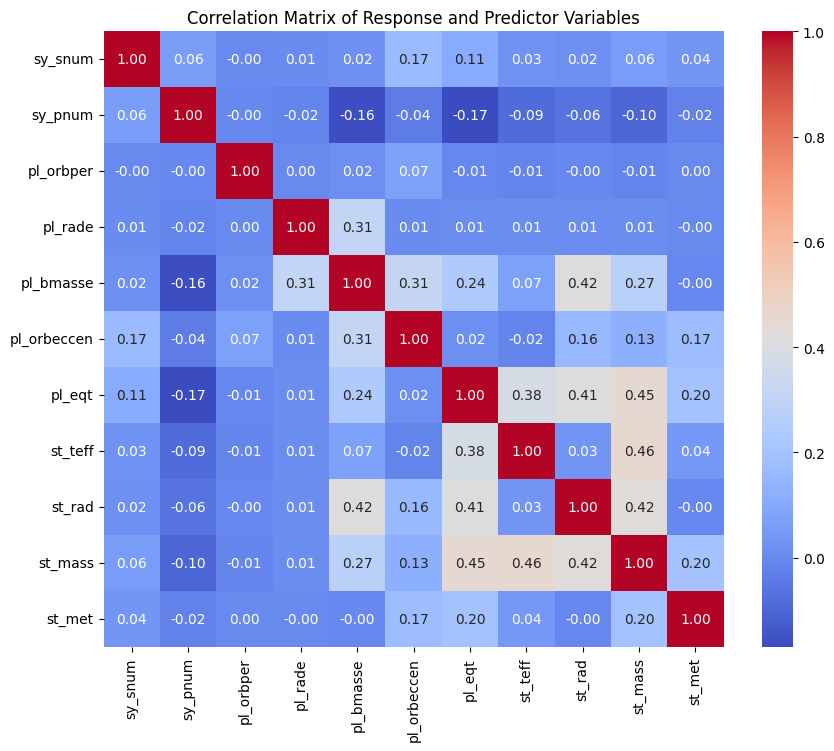

In [ ]:
correlation_matrix = selected_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Response and Predictor Variables')
plt.show()

The correlation matrix above is primarly used to see which variables have a high correlation. The variables with high correlations are those that will be used for further analysis. From the figure, we can see that the highest correlation between response and predictor pairs is planet temp and star radius, temp and mass. Similarly, there is a fairly high correlation between star radius, mass and planet mass.

<a id='final_variables'></a>

## **Final Outcome Variables and Predictor Variables:**


Based on the level of correlation between our response and predictor variable pairs in the above correlation matrix, our final set of Outcome and Predictor response will be as follows:
<br>
<br>
### **First Outcome  & Predictor pairing:**
<br>

**Outcome Variable:**
* Planetary Mass

**Predictors:**
* Stellar Radius  
* Stellar Mass



<br>

### **Second Outcome & Predictor Pairing**
<br>

**Outcome Variable:**
* Planetary Equilibrium Temperature

**Predictors:**
* Stellar Radius
* Stellar Mass
* Stellar Temperature

We will plot the predictor variables versus the response variable to get a bird's eye view of the relationship between the predictor and response variables.

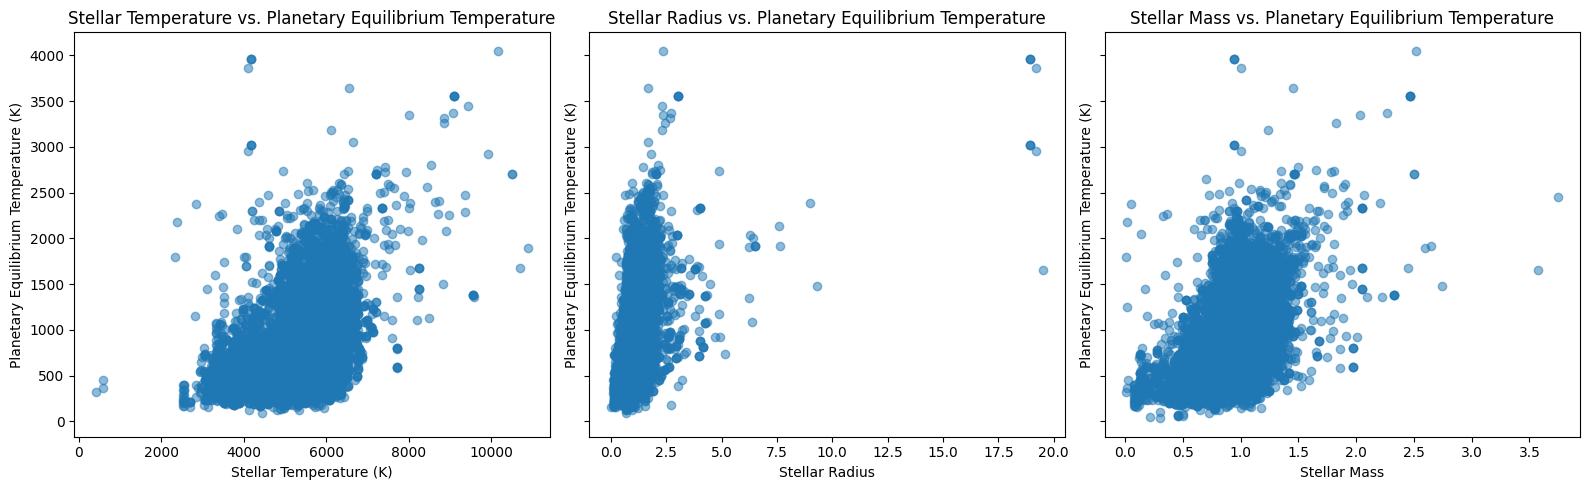

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

ax1.scatter(selected_data['st_teff'], selected_data['pl_eqt'], alpha=0.5)
ax1.set_xlabel('Stellar Temperature (K)')
ax1.set_ylabel('Planetary Equilibrium Temperature (K)')
ax1.set_title('Stellar Temperature vs. Planetary Equilibrium Temperature')

ax2.scatter(selected_data['st_rad'], selected_data['pl_eqt'], alpha=0.5)
ax2.set_xlabel('Stellar Radius')
ax2.set_ylabel('Planetary Equilibrium Temperature (K)')
ax2.set_title('Stellar Radius vs. Planetary Equilibrium Temperature')

ax3.scatter(selected_data['st_mass'], selected_data['pl_eqt'], alpha=0.5)
ax3.set_xlabel('Stellar Mass')
ax3.set_ylabel('Planetary Equilibrium Temperature (K)')
ax3.set_title('Stellar Mass vs. Planetary Equilibrium Temperature')

plt.tight_layout()
plt.show()

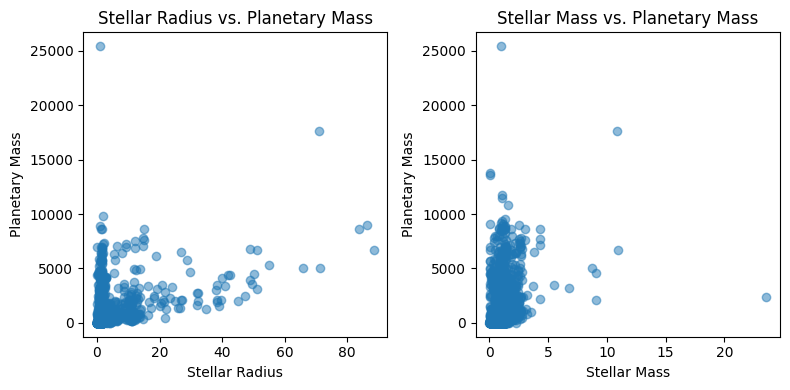

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(selected_data['st_rad'], selected_data['pl_bmasse'], alpha=0.5)
plt.xlabel('Stellar Radius')
plt.ylabel('Planetary Mass')
plt.title('Stellar Radius vs. Planetary Mass')

plt.subplot(1, 2, 2)
plt.scatter(selected_data['st_mass'], selected_data['pl_bmasse'], alpha=0.5)
plt.xlabel('Stellar Mass')
plt.ylabel('Planetary Mass')
plt.title('Stellar Mass vs. Planetary Mass')

plt.tight_layout()
plt.show()

Next we will perform a boxplot visualization as a part of our outlier analysis. The goal of this visualization is to see how much of our data is considered outliers.

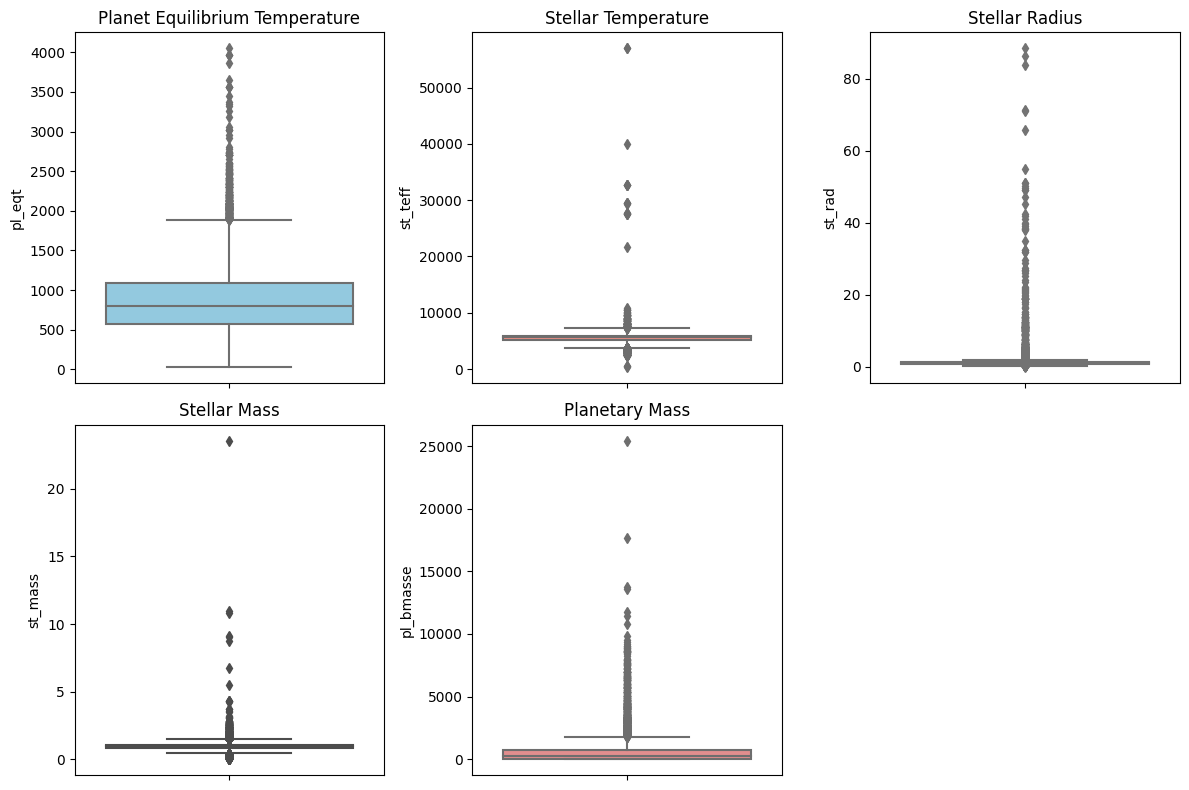

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
sns.boxplot(y=selected_data['pl_eqt'], color='skyblue')
plt.title('Planet Equilibrium Temperature')

plt.subplot(2, 3, 2)
sns.boxplot(y=selected_data['st_teff'], color='salmon')
plt.title('Stellar Temperature')

plt.subplot(2, 3, 3)
sns.boxplot(y=selected_data['st_rad'], color='lightgreen')
plt.title('Stellar Radius')

plt.subplot(2, 3, 4)
sns.boxplot(y=selected_data['st_mass'], color='gold')
plt.title('Stellar Mass')

plt.subplot(2, 3, 5)
sns.boxplot(y=selected_data['pl_bmasse'], color='lightcoral')
plt.title('Planetary Mass')

plt.tight_layout()
plt.show()

From the scatter plot and boxplot visualizations, one important takeaway is that there are a significant number of outliers in our dataset. This will affect our decision when choosing methods to massage the existing data and in the models we end up choosing in our final deliverable.

For our models, we will need to scale the data as the magnitudes in the response and predictor dataset is wildly different. To do this, we use standard scaling as the we know the data is has many outliers. The Standard scaler is a more robust method against outliers.  

In [ ]:
scaler = StandardScaler().fit(selected_data)
array_scaled = scaler.transform(selected_data.values)
column_names = ['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_orbeccen', 'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'st_met']

df_scaled = pd.DataFrame(data=array_scaled, columns=column_names)
print(df_scaled)

        sy_snum   sy_pnum  pl_orbper  pl_rade  pl_bmasse  pl_orbeccen  pl_eqt  \
0      3.035088 -0.736447        NaN      NaN   3.294382          NaN     NaN   
1      3.035088 -0.736447  -0.005917      NaN   3.808614     1.542844     NaN   
2      3.035088 -0.736447  -0.005918      NaN   2.928670     1.600119     NaN   
3     -0.269834 -0.736447  -0.005833      NaN   2.766792     0.307349     NaN   
4     -0.269834 -0.736447        NaN      NaN   1.885643          NaN     NaN   
...         ...       ...        ...      ...        ...          ...     ...   
35110  3.035088  0.940998  -0.005475      NaN   0.353978     1.853764     NaN   
35111 -0.269834 -0.736447  -0.005891      NaN  -0.415215     2.271051     NaN   
35112 -0.269834 -0.736447        NaN      NaN  -0.077571          NaN     NaN   
35113 -0.269834 -0.736447  -0.006001      NaN   0.096912    -0.347219     NaN   
35114 -0.269834 -0.736447  -0.006001      NaN  -0.095227     0.135525     NaN   

        st_teff     st_rad 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


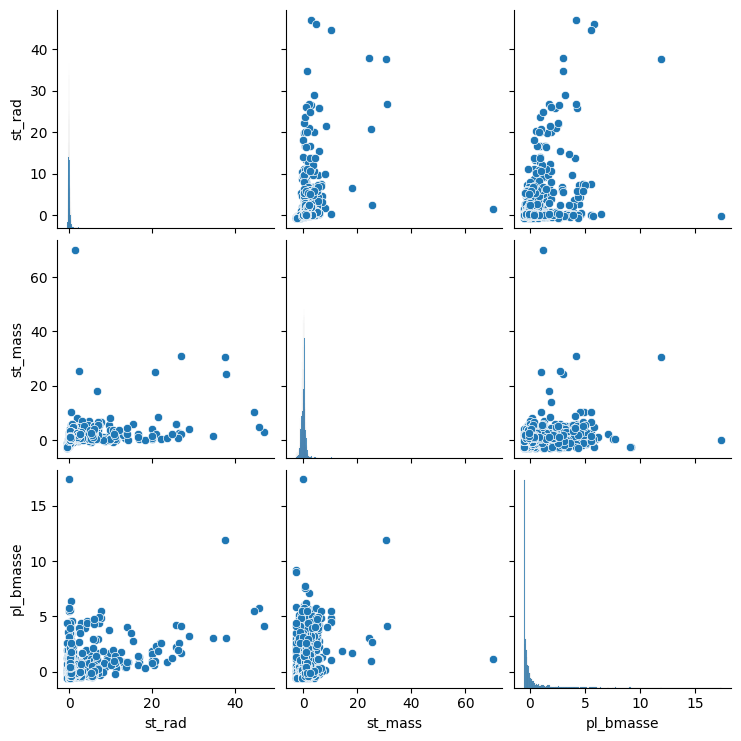

In [ ]:
columns = ['st_rad', 'st_mass', 'pl_bmasse']
selected_df = df_scaled[columns]
sns.pairplot(selected_df)

plt.show()

From the above pairwise plot, we can see that the distribution for the response variable is not a normal distribution. We will keep this in mind when choosing an appropriate model for this dataset.

As the sklearn models cannot handle NaN values, we will need to complete our data using imputation. For the imputation we will start with the simple mean imputation.  Imputation will need to be done for both the response and predictor values.

In [ ]:
X = df_star_clean[['st_mass', 'st_rad']]
y = df_star_clean[['pl_bmasse']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=109)

X_train_impute = X_train.copy()
X_test_impute = X_test.copy()
y_train_impute = y_train.copy()
y_test_impute = y_test.copy()

impute = SimpleImputer(strategy='mean')
X_train_imputevalue = impute.fit_transform(X_train_impute)
X_test_imputevalue = impute.transform(X_test_impute)
y_train_imputevalue = impute.fit_transform(y_train_impute)
y_test_imputevalue = impute.transform(y_test_impute)

Generally, mean imputation will be extremely sensitive to outliers in our dataset. We will also perform a knn_impute using a n_neighbors parameter of 5 to see what improvements this brings to our model.

In [ ]:
knn_impute = KNNImputer(n_neighbors=5, weights='uniform')
X_train_knnimpute = X_train.copy()
X_test_knnimpute = X_test.copy()
y_train_knnimpute = y_train.copy()
y_test_knnimpute = y_test.copy()
X_train_knnimputevalue = knn_impute.fit_transform(X_train_knnimpute)
X_test_knnimputevalue = knn_impute.transform(X_test_knnimpute)
y_train_knnimputevalue = knn_impute.fit_transform(y_train_knnimpute)
y_test_knnimputevalue = knn_impute.transform(y_test_knnimpute)

### Modeling:

The plan will be to create and validate different models for each of the pairs of comparisons that we have mentioned in the EDA portion of this notebook.

The first model to explore is stellar mass and stellar radius vs planetary mass.  Due to the wildly different magnitude of the stellar and planetary features, we will need to first perform scaling. As we need to keep in mind there are a significant number of outliers in our datasets as well as different scales and units for our data, we will use the standard scaling method.

<a id='linear'></a>
## First Model: Linear Regression
[Return to contents](#contents1)

For our first model we will fit the data using a linear regression model. from the scatter plots comparing the predictor and response, we can eyeball a linear relationship. We will first go through possible degrees of the linear model and see if we can find a best degree.

In [ ]:
def polynomial_regression_analysis(X_train, y_train, X_test, y_test, title):
    """
    Perform polynomial regression analysis with varying polynomial degrees.

    Parameters:
    - X_train: Training features
    - y_train: Training target variable
    - X_test: Test features
    - y_test: Test target variable

    Returns:
    - None (displays a plot of MSE vs. polynomial degree)
    """

    train_mses = []
    val_mses = []
    degrees = range(1, 14)

    for degree in degrees:
        #Transform features to polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_poly_train = poly.fit_transform(X_train)
        x_poly_test = poly.fit_transform(X_test)

        #Fit a linear regression model
        model = LinearRegression(fit_intercept=True)
        model.fit(x_poly_train, y_train)

        #Predict on training and test sets
        y_train_pred = model.predict(x_poly_train)
        y_val_pred = model.predict(x_poly_test)

        #Calculate and store the MSE for training and validation
        train_mse = mean_squared_error(y_train, y_train_pred)
        val_mse = mean_squared_error(y_test, y_val_pred)

        train_mses.append(train_mse)
        val_mses.append(val_mse)

    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_mses, marker='o', label='Train MSE', color='b')
    plt.plot(degrees, val_mses, marker='o', label='Validation MSE', color='r')

    # Identify the degree with the lowest validation error
    best_degree_test = degrees[np.argmin(val_mses)]
    best_degree_train = degrees[np.argmin(train_mses)]

    min_val_mse = min(val_mses)
    min_train_mse = min(train_mses)
    plt.scatter(best_degree_test, min_val_mse, color='g', marker='x', s=100, label='Best Degree Test')
    plt.scatter(best_degree_train, min_train_mse, color='b', marker='x', s=100, label='Best Degree train')

    plt.yscale('log')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('MSE')
    #plt.title('Train and Validation MSE vs. Polynomial Degree')
    plt.title(title)
    plt.legend(loc=2)
    plt.show()

    print(f'The best MSE score with the best degree is {min_val_mse:.4f} for degree {best_degree_test}')

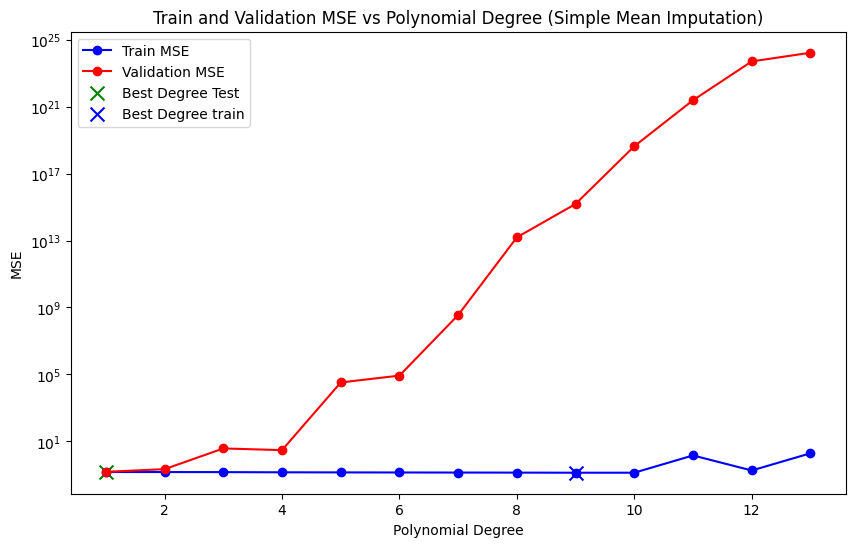

The best MSE score with the best degree is 0.1507 for degree 1


In [ ]:
polynomial_regression_analysis(X_train_imputevalue, y_train_imputevalue, X_test_imputevalue, y_test_imputevalue, "Train and Validation MSE vs Polynomial Degree (Simple Mean Imputation)")

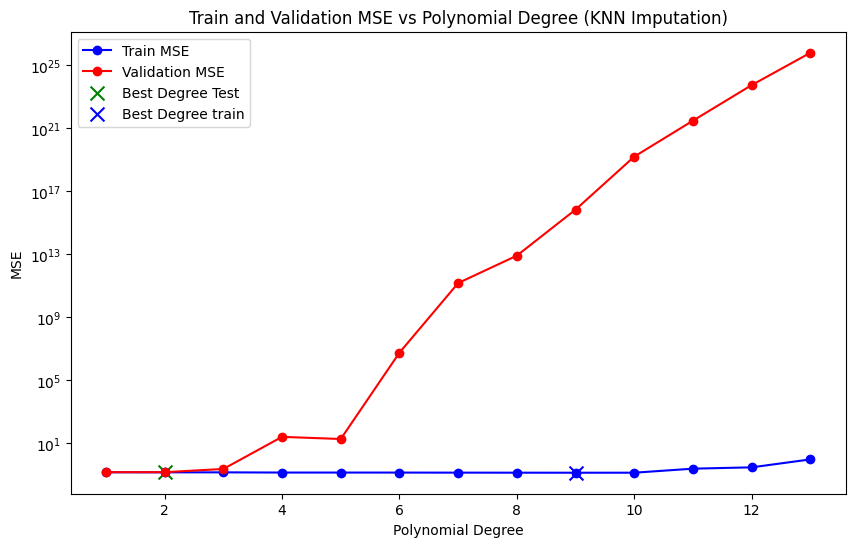

The best MSE score with the best degree is 0.1473 for degree 2


In [ ]:
polynomial_regression_analysis(X_train_knnimputevalue, y_train_knnimputevalue, X_test_knnimputevalue, y_test_knnimputevalue, "Train and Validation MSE vs Polynomial Degree (KNN Imputation)")

In both polynomial regression models using knn and mean imputation on the dataset, we see the same pattern of the model being heavily overfit on the training data and then performing poorly on the test data.

In our pairwise plots, we see that the distrubution is not a normal distrbution for our response variable. Because of this, we will need to rely on regression methods that work on nonlinear relationships.


In [ ]:
def evaluate_model(model,y_test, y_test_pred,y_train,y_train_pred,list):
  best_r2_val = r2_score(y_test, y_test_pred)

  best_mse_val = mean_squared_error(y_test, y_test_pred)

  best_r2_train = r2_score(y_train, y_train_pred)

  best_mse_train = mean_squared_error(y_train, y_train_pred)

  list.append({'model': model,'train_mse': best_mse_train, 'train_R2': best_r2_train, 'test_mse': best_mse_val, 'test_R2': best_r2_val})
  print(f'The R^2 score of the best {model} model using the training data is {best_r2_train:.4f}')
  print(f'The  MSE score of the best {model} model using the training data is {best_mse_train:.4f}')
  print(f'The R^2 score of the best {model} model is {best_r2_val:.4f}')
  print(f'The  MSE score of the best {model} model is {best_mse_val:.4f}')

In [ ]:
all_scores = []
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
x_poly_train = poly.fit_transform(X_train_knnimputevalue)
x_poly_test = poly.fit_transform(X_test_knnimputevalue)

model = LinearRegression(fit_intercept=True)
model.fit(x_poly_train, y_train_knnimputevalue)

y_train_pred = model.predict(x_poly_train)
y_val_pred = model.predict(x_poly_test)

evaluate_model('Linear Regression',y_test_knnimputevalue, y_val_pred,y_train_knnimputevalue,y_train_pred,all_scores)

The R^2 score of the best Linear Regression model using the training data is 0.1024
The  MSE score of the best Linear Regression model using the training data is 0.1441
The R^2 score of the best Linear Regression model is 0.0868
The  MSE score of the best Linear Regression model is 0.1473


In [ ]:
pd.DataFrame(all_scores)

,model,train_mse,train_R2,test_mse,test_R2
0,Linear Regression,0.144076,0.102356,0.147296,0.086774


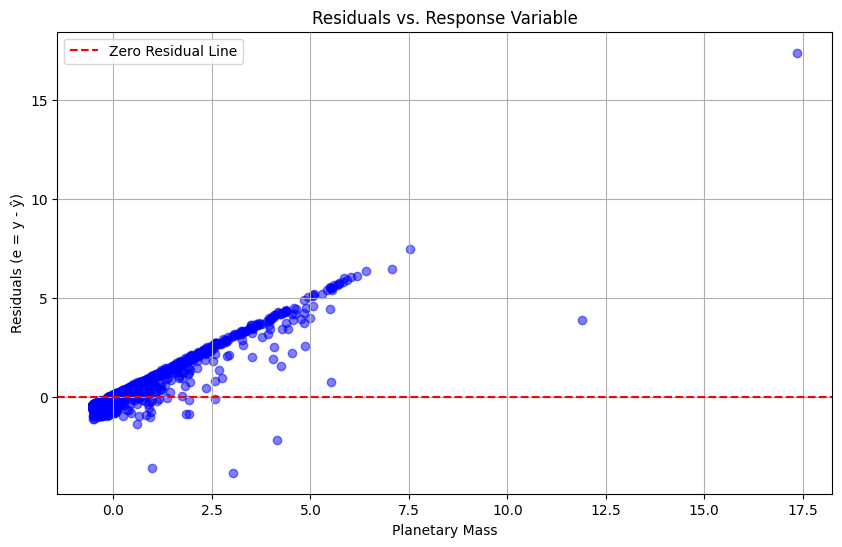

In [ ]:
residuals = y_train_knnimpute - y_train_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_train_imputevalue, residuals, c='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals vs. Response Variable')
plt.xlabel('Planetary Mass')
plt.ylabel('Residuals (e = y - ŷ)')
plt.legend()
plt.grid(True)
plt.show()

This model with the knn imputation (k neighbors = 5) outperforms the model with simple mean imputation. This is not unexpected as using knn imputation with a higher number of k neighbors would make the imputation less susceptible to outliers that are prevalent in our dataset.

The best polynomial model does not have a great  R2 value. Considering the fact that in our pairwise visualization the distribution of the response variable was not a normal distribution  as well as the residual plot not holding the assumption of linearity, it is not surprising linear regression is not the best model for the job.

<a id='knn'></a>
## Second Model: KNN
[Return to contents](#contents1)

We will be testing on non-linear regression models to see if this fits the response data better. We will start with KNN and bagging

In order to find the best k in knn, we will start of with using cross validation with 10 folds.

In [ ]:
def knn_cross_validation_analysis(X_train, y_train, k_values, cv=10):
    """
    Perform k-NN cross-validation analysis with varying k values.

    Parameters:
    - X_train: Training features
    - y_train: Training target variable
    - k_values: List of k values to try
    - cv: Number of cross-validation folds

    Returns:
    - None (displays a plot of MSE vs. k)
    """

    train_mses_mean_knn = []
    val_mses_mean_knn = []

    for k in k_values:
        knn_model = KNeighborsRegressor(n_neighbors=k)
        knn_model.fit(X_train, y_train)

        scores = cross_validate(knn_model, X_train, y_train, cv=cv, scoring=('neg_mean_squared_error'), return_train_score=True)

        train_mse_mean = -np.mean(scores['train_score'])
        val_mse_mean = -np.mean(scores['test_score'])

        train_mses_mean_knn.append(train_mse_mean)
        val_mses_mean_knn.append(val_mse_mean)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, train_mses_mean_knn, marker='o', label='Train MSE', color='b')
    plt.plot(k_values, val_mses_mean_knn, marker='o', label='Validation MSE', color='r')

    # Identify the k with the lowest validation error
    best_k = k_values[np.argmin(val_mses_mean_knn)]

    min_val_mse = min(val_mses_mean_knn)
    plt.scatter(best_k, min_val_mse, color='g', marker='x', s=100, label='Best K')

    plt.yscale('log')
    plt.xlabel('K (number of neighbors)')
    plt.ylabel('MSE')
    plt.title('Train and Validation MSE vs. K')
    plt.legend(loc=0)
    plt.show()

    print(f'The best MSE score with the best k is {min_val_mse:.4f} for k = {best_k}')

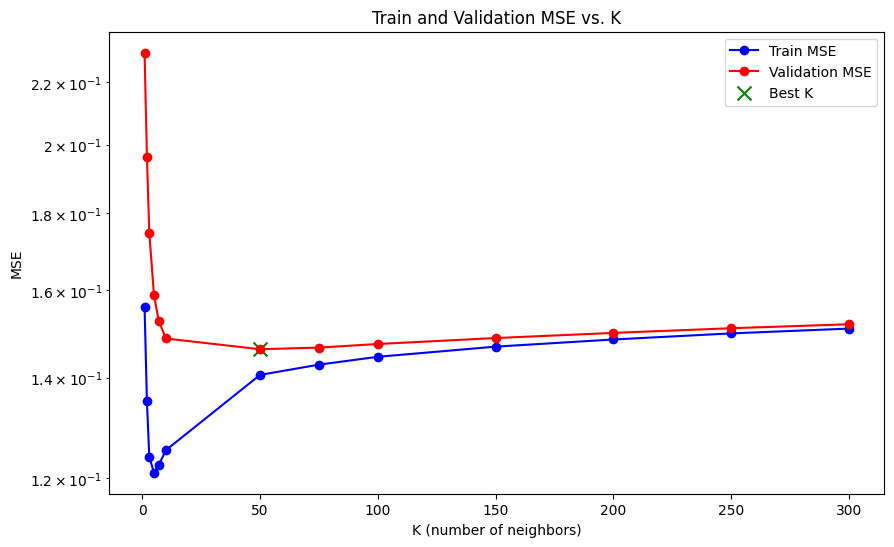

The best MSE score with the best k is 0.1462 for k = 50


In [ ]:
k_values = [1, 2, 3, 5, 7, 10, 50,75, 100,150,200,250,300]
knn_cross_validation_analysis(X_train_knnimputevalue, y_train_knnimputevalue, k_values)

In [ ]:
best_k = 50
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_knnimputevalue, y_train_knnimputevalue)

y_hat_train = knn_model.predict(X_train_knnimputevalue)
y_hat_test = knn_model.predict(X_test_knnimputevalue)

evaluate_model('KNN',y_test_knnimputevalue, y_hat_test,y_train_knnimputevalue,y_hat_train,all_scores)

The R^2 score of the best KNN model using the training data is 0.1263
The  MSE score of the best KNN model using the training data is 0.1402
The R^2 score of the best KNN model is 0.0950
The  MSE score of the best KNN model is 0.1460


In [ ]:
pd.DataFrame(all_scores)

,model,train_mse,train_R2,test_mse,test_R2
0,Linear Regression,0.144076,0.102356,0.147296,0.086774
1,KNN,0.140227,0.126335,0.145968,0.095008


For the Knn model, we continued to use our knn imputed dataset.

With the KNN model, we are still running into a very low R2 score. The biased distribution may be too complex for knn and linear regression to handle. For the third model we will rely on decision tree combined with bagging for a robust model.

<a id='bagging'></a>
## Third Model: Decision Tree Regression Combined with Bagging
[Return to contents](#contents1)

Now we create a model using a combination of Decision tree and bagging. This is so that we can take advantage of a decision tree regressor which can handle a nonlinear relationship to serve as a powerful base model. The bagging on top helps to generalize these nonlinear relationships making this model even suitable for complex relationships.

Again to determine the hyper parameter max_depth for the base decision tree model and n_estimators for the bagging regressor, we will use CV. For our dataset, we will continue to use knn imputes.

In [ ]:
train_scores = []
cvmean = []

for depth in range(1,51):
  tree = DecisionTreeRegressor(max_depth=depth, random_state=0)
  train_scores.append(tree.fit(X_train_knnimputevalue, y_train_knnimputevalue).score(X_train_knnimputevalue, y_train_knnimputevalue))

  scores = cross_val_score(estimator=tree,X=X_train_knnimputevalue, y=y_train_knnimputevalue, cv=5, scoring='neg_mean_squared_error')
  cvmean.append(-scores.mean())

In [ ]:
def plot_accuracy(depths, train_scores, cvmeans, title, set_ylim=False):
    """ Plots non-cross-validation training scores, mean validation scores
    and a shaded region that illustrates +/- 2 standard deviation validation
    bounds for each tree depth.

    :param depths: list, max tree depth
    :param train_scores: list, non-cross-validation training scores
    :param cvmeans: list, mean validation scores for each depth
    :param cvstds: list, standard deviation of mean validation scores for each depth
    :param title: str, plot title
    :param ylim: bool, to focus plot on just mean validation +/- 2 standard
                 deviations. Default is False
    """

    fig, ax = plt.subplots(1, 1, figsize=(20, 4))

    fig.suptitle(title)

    ax.grid(':', alpha=0.4)
    ax.set_xticks(depths)

    cvmeans_arr = np.array(cvmeans)

    ax.plot(depths, cvmeans, marker='d', label='Mean Validation Score')
    best_index = np.argmax(cvmean)
    if set_ylim:
        ylim=plt.ylim()
        plt.ylim(ylim)

    ax.plot(depths, train_scores, marker='o', label='Training Score')
    ax.xlabel='Accuracy'
    ax.ylabel='Depths'
    ax.legend()

    print(f"The depth corresponding to the highest cvmean score is: {best_index-1}")

The index of the highest cvmean score is: 28


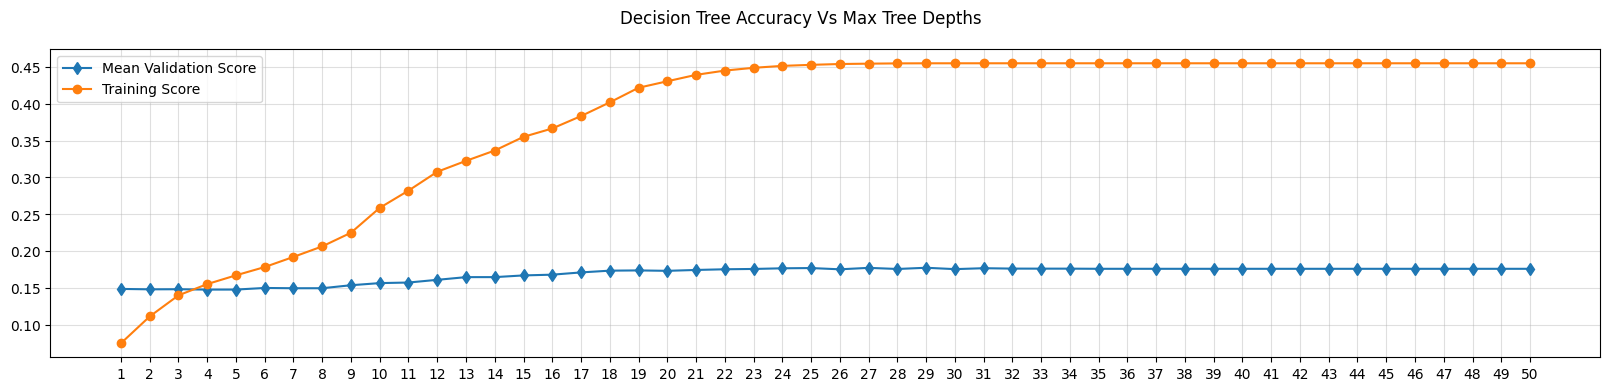

In [ ]:
depths=range(1, 51)
plot_accuracy(depths, train_scores, cvmean, 'Decision Tree Accuracy Vs Max Tree Depths')

Since we are planning to use bagging as our ensemble method to reduce overall variance in the model, we will use the highest depth possible for our base model before accuracy plateaus. Using this line of thinking, we will use **max_depth = 27**.

In [ ]:
y_train_ravel = y_train_knnimputevalue.ravel()

train_mses_mean = []
val_mses_mean = []
val_mses_std = []

for n_estimators in [5, 10,50,100,200,300,400, 500, 600]:
    base_model = DecisionTreeRegressor(max_depth=27, random_state=109)

    bagging_regressor = BaggingRegressor(base_model,n_estimators=n_estimators, random_state=109)
    scores = cross_validate(bagging_regressor, X_train_knnimputevalue, y_train_ravel, cv = 5, scoring=('neg_mean_squared_error'), return_train_score=True)

    train_mse_mean = -np.mean(scores['train_score'])
    val_mse_mean = -np.mean(scores['test_score'])

    train_mses_mean.append(train_mse_mean)
    val_mses_mean.append(val_mse_mean)

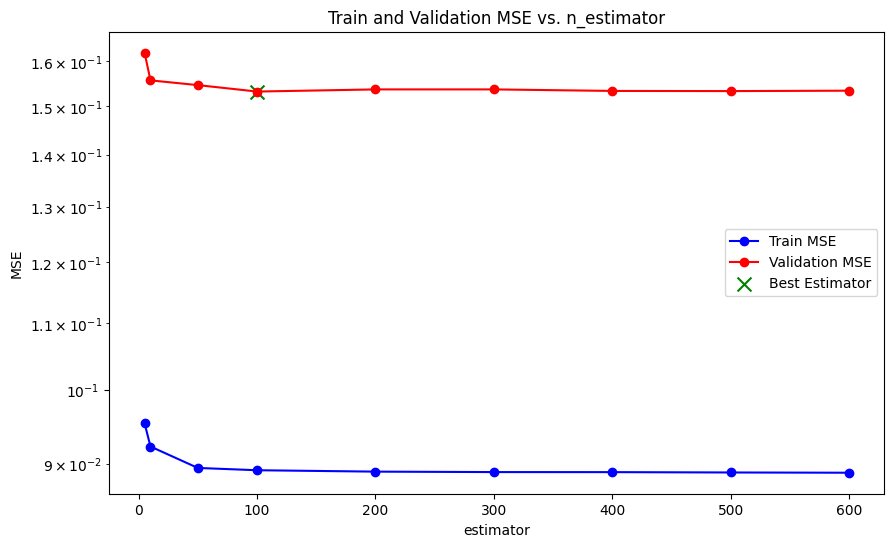

In [ ]:
estimators = [5, 10,50,100,200,300,400, 500, 600]
plt.figure(figsize=(10, 6))
plt.plot(estimators, train_mses_mean, marker='o', label='Train MSE', color='b')
plt.plot(estimators, val_mses_mean, marker='o', label='Validation MSE', color='r')

#Identify the degree with the lowest validation error
best_estimator= estimators[np.argmin(val_mses_mean)]

min_val_mse = min(val_mses_mean)
plt.scatter(best_estimator, min_val_mse, color='g', marker='x', s=100, label='Best Estimator')

plt.yscale('log')
plt.xlabel('estimator')
plt.ylabel('MSE')
plt.title('Train and Validation MSE vs. n_estimator')
plt.legend(loc=0)
plt.show()

In [ ]:
best_estimator

100

In [ ]:
base_model = DecisionTreeRegressor(max_depth=26, random_state=109)
bagging_regressor = BaggingRegressor(base_model,n_estimators=best_estimator, random_state=109)
bagging_regressor.fit(X_train_knnimputevalue, y_train_ravel)

y_test_pred = bagging_regressor.predict(X_test_knnimputevalue)
y_train_pred = bagging_regressor.predict(X_train_knnimputevalue)

evaluate_model('Decision Tree + Bagging',y_test_knnimputevalue, y_test_pred,y_train_knnimputevalue,y_train_pred,all_scores)

The R^2 score of the best Decision Tree + Bagging model using the training data is 0.4259
The  MSE score of the best Decision Tree + Bagging model using the training data is 0.0921
The R^2 score of the best Decision Tree + Bagging model is 0.0225
The  MSE score of the best Decision Tree + Bagging model is 0.1577


In [ ]:
pd.DataFrame(all_scores)

,model,train_mse,train_R2,test_mse,test_R2
0,Linear Regression,0.144076,0.102356,0.147296,0.086774
1,KNN,0.140227,0.126335,0.145968,0.095008
2,Decision Tree + Bagging,0.092143,0.425913,0.157664,0.022493


The decision tree model is still overfitting the training data even though an ensemble method has been utilized to help it generalize. Perhaps we can improve performance if we choose a more reasonable max_depth in the base decision tree model.

From the *Tree Accuracy vs Tree Depths* chart, a reasonable depth would be 9 as that provides a reasonable CV score but will significantly cut down on overfitting. We will repeat the CV process to find n_estimators using this new depth.  

In [ ]:
train_mses_mean = []
val_mses_mean = []
val_mses_std = []

for n_estimators in [5, 10,50,100,200,300,400, 500, 600]:
    base_model = DecisionTreeRegressor(max_depth=9, random_state=109)

    bagging_regressor = BaggingRegressor(base_model,n_estimators=n_estimators, random_state=109)
    scores = cross_validate(bagging_regressor, X_train_knnimputevalue, y_train_ravel, cv = 5, scoring=('neg_mean_squared_error'), return_train_score=True)

    train_mse_mean = -np.mean(scores['train_score'])
    val_mse_mean = -np.mean(scores['test_score'])

    train_mses_mean.append(train_mse_mean)
    val_mses_mean.append(val_mse_mean)

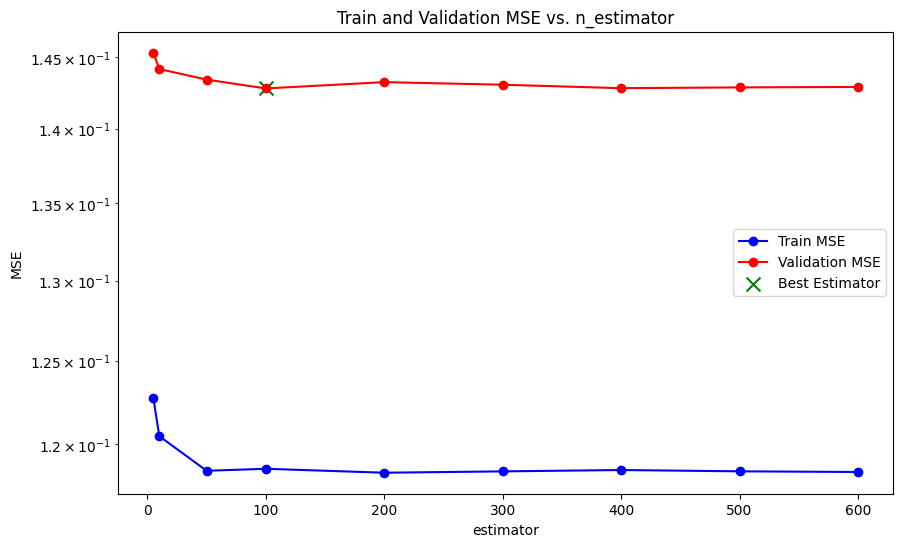

In [ ]:
estimators = [5, 10,50,100,200,300,400, 500, 600]
plt.figure(figsize=(10, 6))
plt.plot(estimators, train_mses_mean, marker='o', label='Train MSE', color='b')
plt.plot(estimators, val_mses_mean, marker='o', label='Validation MSE', color='r')

#Identify the degree with the lowest validation error
best_estimator= estimators[np.argmin(val_mses_mean)]

min_val_mse = min(val_mses_mean)
plt.scatter(best_estimator, min_val_mse, color='g', marker='x', s=100, label='Best Estimator')

plt.yscale('log')
plt.xlabel('estimator')
plt.ylabel('MSE')
plt.title('Train and Validation MSE vs. n_estimator')
plt.legend(loc=0)
plt.show()

In [ ]:
base_model = DecisionTreeRegressor(max_depth=9, random_state=109)
bagging_regressor = BaggingRegressor(base_model,n_estimators=best_estimator, random_state=109)
bagging_regressor.fit(X_train_knnimputevalue, y_train_ravel)

y_test_pred = bagging_regressor.predict(X_test_knnimputevalue)
y_train_pred = bagging_regressor.predict(X_train_knnimputevalue)

evaluate_model('Decision Tree (Shallower) + Bagging',y_test_knnimputevalue, y_test_pred,y_train_knnimputevalue,y_train_pred,all_scores)

The R^2 score of the best Decision Tree (Shallower) + Bagging model using the training data is 0.2488
The  MSE score of the best Decision Tree (Shallower) + Bagging model using the training data is 0.1206
The R^2 score of the best Decision Tree (Shallower) + Bagging model is 0.1117
The  MSE score of the best Decision Tree (Shallower) + Bagging model is 0.1433


In [ ]:
pd.DataFrame(all_scores)

,model,train_mse,train_R2,test_mse,test_R2
0,Linear Regression,0.144076,0.102356,0.147296,0.086774
1,KNN,0.140227,0.126335,0.145968,0.095008
2,Decision Tree + Bagging,0.092143,0.425913,0.157664,0.022493
3,Decision Tree (Shallower) + Bagging,0.120572,0.248795,0.143273,0.111716


In [ ]:
def plot_all_scores(listname):
  df_all_scores = pd.DataFrame(listname)
  df_all_scores.set_index('model', inplace=True)

  fig, axes = plt.subplots(nrows=2, figsize=(10, 12), gridspec_kw={'hspace': 0.9})
  bar_width = 0.3
  bar_positions_train = range(len(df_all_scores))
  bar_positions_test = [pos + bar_width for pos in bar_positions_train]

  train_mse_bars= axes[0].bar(bar_positions_train, df_all_scores['train_mse'], width=bar_width, label='Train MSE')
  test_mse_bars = axes[0].bar(bar_positions_test, df_all_scores['test_mse'], width=bar_width, label='Test MSE')

  for bar in train_mse_bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')
  for bar in test_mse_bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

  axes[0].set_xticks([pos + bar_width / 2 for pos in bar_positions_train])
  axes[0].set_xticklabels(df_all_scores.index, rotation=45, ha='right')
  axes[0].set_xlabel('Model')
  axes[0].set_ylabel('Mean Squared Error')
  axes[0].set_title('Train and Test Mean Squared Error for Different Models')
  axes[0].legend()

  train_R2_bars=axes[1].bar(bar_positions_train, df_all_scores['train_R2'], width=bar_width, label='Train R2')
  test_R2_bars=axes[1].bar(bar_positions_test, df_all_scores['test_R2'], width=bar_width, label='Test R2')

  for bar in train_R2_bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

  for bar in test_R2_bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

  axes[1].set_xticks([pos + bar_width / 2 for pos in bar_positions_train])
  axes[1].set_xticklabels(df_all_scores.index, rotation=45, ha='right')
  axes[1].set_xlabel('Model')
  axes[1].set_ylabel('R-squared Score')
  axes[1].set_title('Train and Test R-squared Score for Different Models')
  axes[1].legend()

  plt.show()

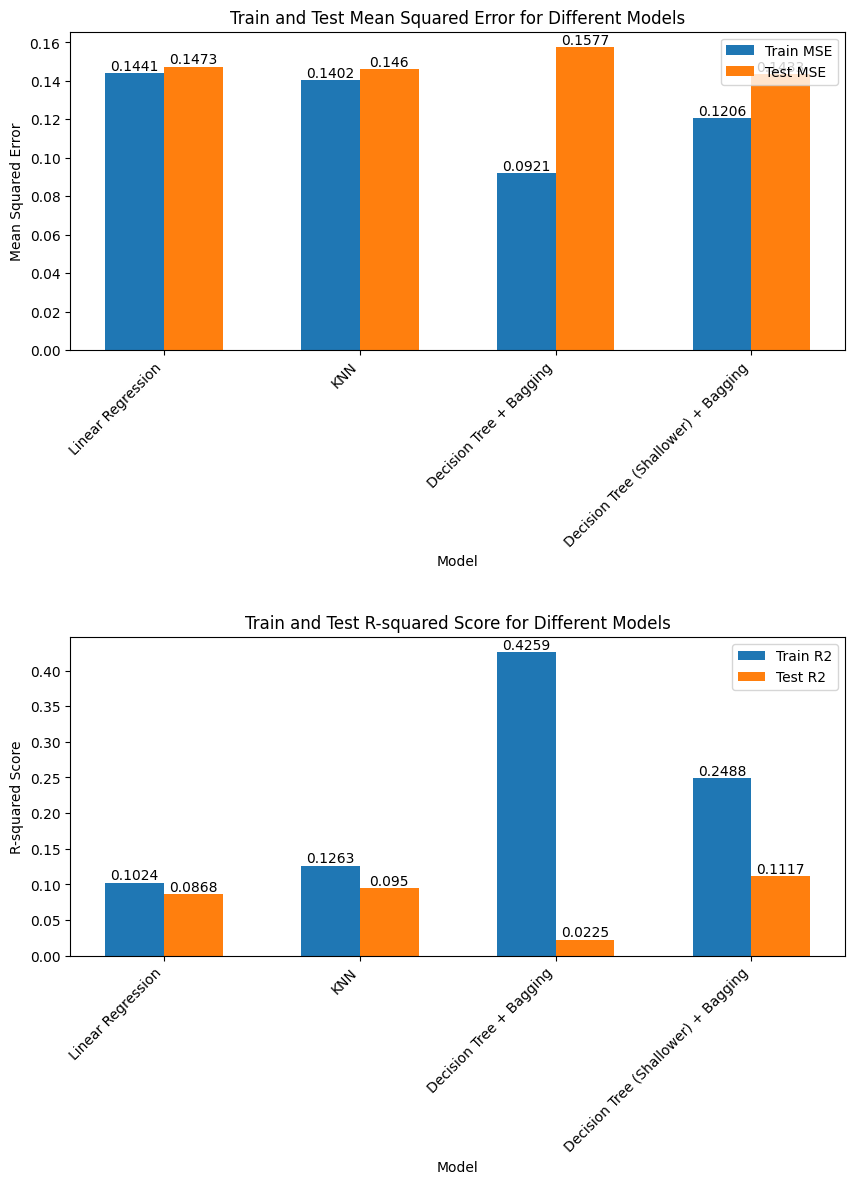

In [ ]:
plot_all_scores(all_scores)

## Model to Predict Planetary Temperature

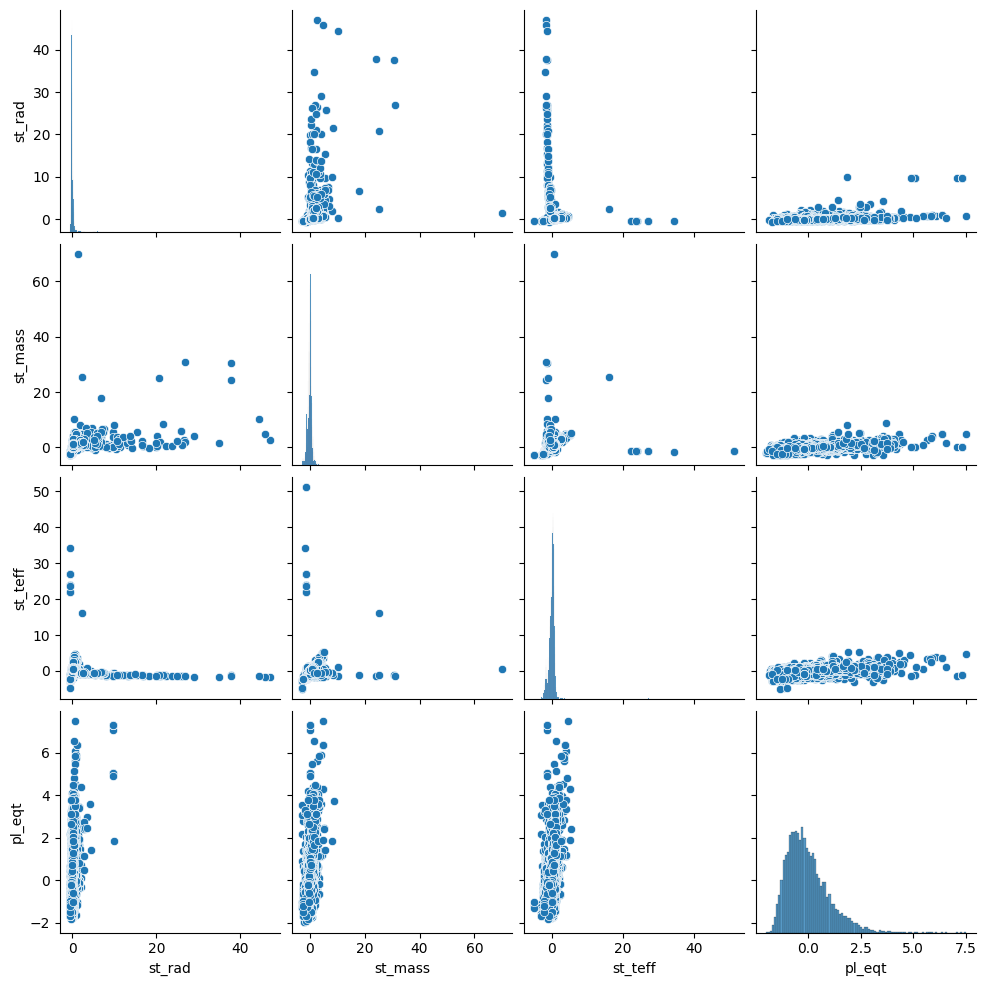

In [ ]:
columns = ['st_rad', 'st_mass','st_teff', 'pl_eqt']
selected_df_temp = df_scaled[columns]
sns.pairplot(selected_df_temp)

plt.show()

Use KNN inputations using the n_neighbors parameter set to 5. Just like in our first model, this helps reduce the sensitivity to outliers in our data.

In [ ]:
X = df_scaled[['st_mass', 'st_rad', 'st_teff']]
y = df_scaled[['pl_eqt']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=109)
X_train_impute = X_train.copy()
X_test_impute = X_test.copy()
y_train_impute = y_train.copy()
y_test_impute = y_test.copy()

knn_impute = KNNImputer(n_neighbors=5, weights='uniform')
X_train_knnimputevalue = knn_impute.fit_transform(X_train_impute)
X_test_knnimputevalue = knn_impute.transform(X_test_impute)

y_train_knnimputevalue = knn_impute.fit_transform(y_train_impute)
y_test_knnimputevalue = knn_impute.transform(y_test_impute)

<a id='linear_second'></a>
## First model for Planet Equilibrium Temp: Polynomial Regression
[Return to contents](#contents1)

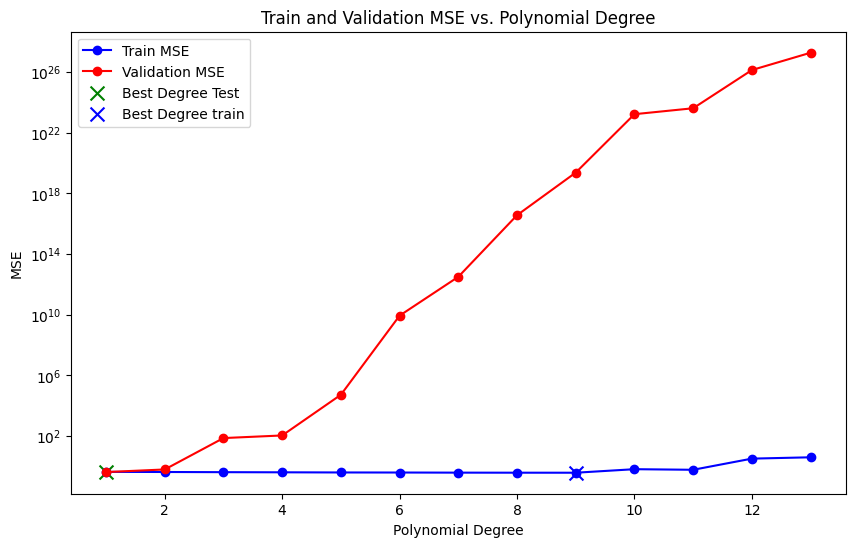

The best MSE score with the best degree is 0.4186 for degree 1


In [ ]:
polynomial_regression_analysis(X_train_knnimputevalue, y_train_knnimputevalue, X_test_knnimputevalue, y_test_knnimputevalue)

In [ ]:
all_scores_pleqt =[]
degree = 1
poly = PolynomialFeatures(degree=degree, include_bias=False)
x_poly_train = poly.fit_transform(X_train_knnimputevalue)
x_poly_test = poly.fit_transform(X_test_knnimputevalue)

# Fit a linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(x_poly_train, y_train_knnimputevalue)

# Predict on training and test sets
y_train_pred = model.predict(x_poly_train)
y_val_pred = model.predict(x_poly_test)

evaluate_model('Polynomial Regression',y_test_knnimputevalue, y_val_pred,y_train_knnimputevalue,y_train_pred,all_scores_pleqt)


The R^2 score of the best Polynomial Regression model using the training data is 0.0723
The  MSE score of the best Polynomial Regression model using the training data is 0.4309
The R^2 score of the best Polynomial Regression model is 0.0438
The  MSE score of the best Polynomial Regression model is 0.4186


The linear model with simple mean imputation came up as the most accurate. However this model may not be the best tool to use since the assumption of linearity might not hold. To confirm this, we can make a residuals plot.

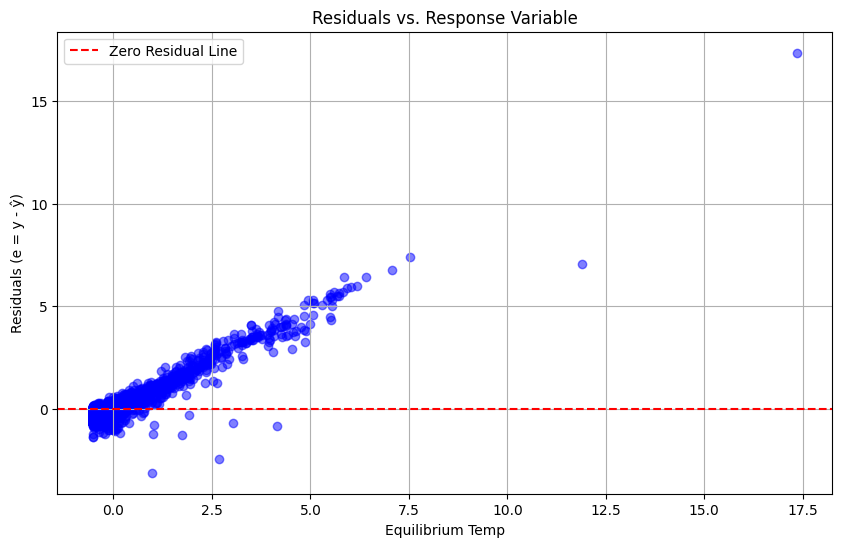

In [ ]:
residuals = y_train_imputevalue - y_train_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_train_knnimpute, residuals, c='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals vs. Response Variable')
plt.xlabel('Equilibrium Temp')
plt.ylabel('Residuals (e = y - ŷ)')
plt.legend()
plt.grid(True)
plt.show()

This linear regression model shows poor R2 score and fairly high MSE. This is surprising as the distribution of the data is a normal distribution so one would assume a linear regression model would do a decent job describing this dataset. However from the residuals plot, we can tell that the assumption of linearity does not hold. This would make the linear regression model a bad choice to describe this dataset.

<a id='knn_second'></a>
## Second model for Planet Equilibrium Temp: KNN
[Return to contents](#contents1)

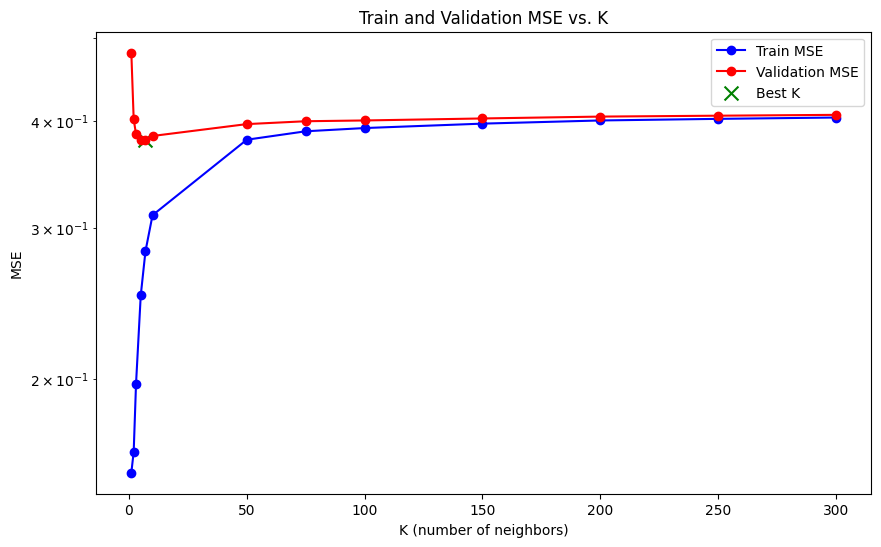

The best MSE score with the best k is 0.3796 for k = 7


In [ ]:
k_values = [1, 2, 3, 5, 7, 10, 50,75, 100,150,200,250,300]
knn_cross_validation_analysis(X_train_knnimputevalue, y_train_knnimputevalue, k_values)

In [ ]:
best_k = 7
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_knnimputevalue, y_train_knnimputevalue)

y_hat_train = knn_model.predict(X_train_knnimputevalue)
y_hat_test = knn_model.predict(X_test_knnimputevalue)

evaluate_model('KNN',y_test_knnimputevalue, y_hat_test,y_train_knnimputevalue,y_hat_train,all_scores_pleqt)

The R^2 score of the best KNN model using the training data is 0.4021
The  MSE score of the best KNN model using the training data is 0.2777
The R^2 score of the best KNN model is 0.1510
The  MSE score of the best KNN model is 0.3716


In [ ]:
pd.DataFrame(all_scores_pleqt)

,model,train_mse,train_R2,test_mse,test_R2
0,Polynomial Regression,0.430889,0.072289,0.418559,0.043782
1,KNN,0.277717,0.402072,0.371647,0.150954


The resulting model after doing some tuning for the k value shows a fairly robust R2 score especially when compared to our polynomial regression.

<a id='bagging_second'></a>
## Third model for Equilibrium Temp: Decision Tree with Bagging
[Return to contents](#contents1)

Like with our first model, we will use a decision tree regression model coupled with a bagging ensemble technique to see if we can come up with a more robust model that can fit to this dataset. We will start with Cross validation to find the optimum decision tree depth and then using that depth, we will use CV to find the best n_estimator hyper parameter.

In [ ]:
train_scores = []
cvmean = []

for depth in range(1,51):
  tree = DecisionTreeRegressor(max_depth=depth, random_state=0)
  train_scores.append(tree.fit(X_train_knnimputevalue, y_train_knnimputevalue).score(X_train_knnimputevalue, y_train_knnimputevalue))

  scores = cross_val_score(estimator=tree,X=X_train_knnimputevalue, y=y_train_knnimputevalue, cv=5, scoring='neg_mean_squared_error')
  cvmean.append(-scores.mean())

The index of the highest cvmean score is: 32


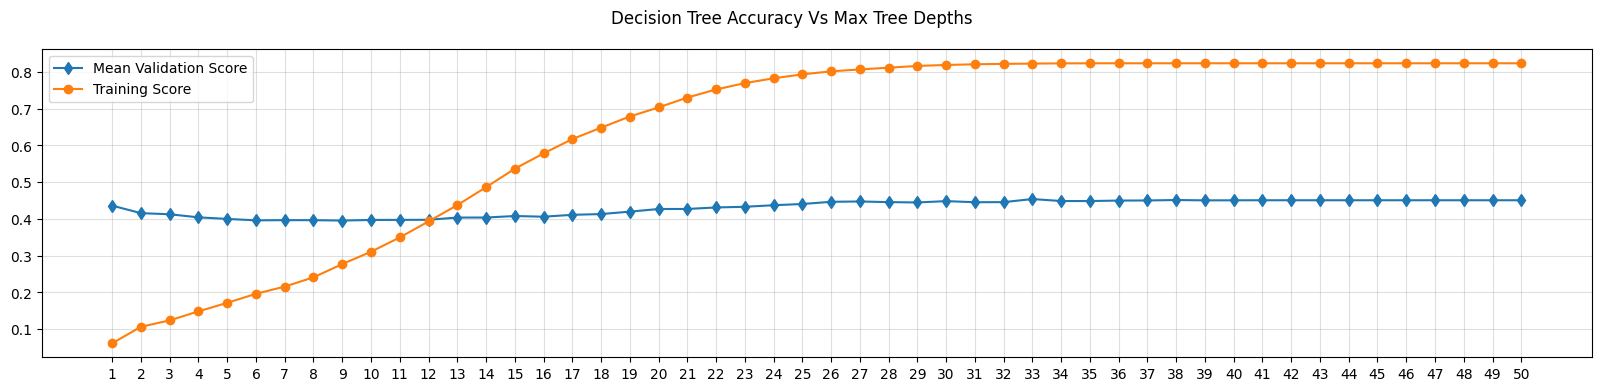

In [ ]:
depths=range(1, 51)
plot_accuracy(depths, train_scores, cvmean, 'Decision Tree Accuracy Vs Max Tree Depths')

In [ ]:
y_train_ravel = y_train_knnimputevalue.ravel()

train_mses_mean = []
val_mses_mean = []
val_mses_std = []

for n_estimators in [5, 10,50,100,200,300,400, 500, 600]:
    base_model = DecisionTreeRegressor(max_depth=33, random_state=109)

    bagging_regressor = BaggingRegressor(base_model,n_estimators=n_estimators, random_state=109)
    scores = cross_validate(bagging_regressor, X_train_knnimputevalue, y_train_ravel, cv = 5, scoring=('neg_mean_squared_error'), return_train_score=True)

    train_mse_mean = -np.mean(scores['train_score'])
    val_mse_mean = -np.mean(scores['test_score'])

    train_mses_mean.append(train_mse_mean)
    val_mses_mean.append(val_mse_mean)

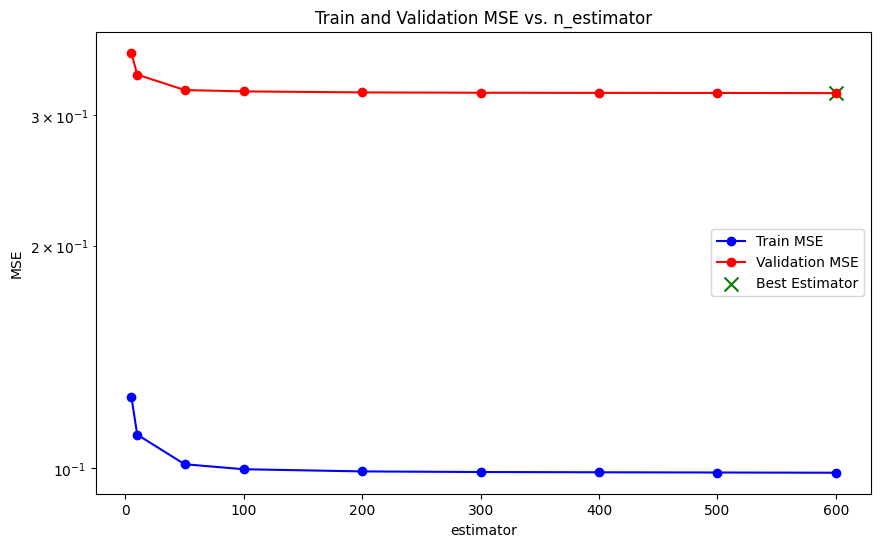

In [ ]:
estimators = [5, 10,50,100,200,300,400, 500, 600]
plt.figure(figsize=(10, 6))
plt.plot(estimators, train_mses_mean, marker='o', label='Train MSE', color='b')
plt.plot(estimators, val_mses_mean, marker='o', label='Validation MSE', color='r')

#Identify the degree with the lowest validation error
best_estimator= estimators[np.argmin(val_mses_mean)]

min_val_mse = min(val_mses_mean)
plt.scatter(best_estimator, min_val_mse, color='g', marker='x', s=100, label='Best Estimator')

plt.yscale('log')
plt.xlabel('estimator')
plt.ylabel('MSE')
plt.title('Train and Validation MSE vs. n_estimator')
plt.legend(loc=0)
plt.show()

In [ ]:
base_model = DecisionTreeRegressor(max_depth=33, random_state=109)

bagging_regressor = BaggingRegressor(base_model, n_estimators = best_estimator, random_state=109)
bagging_regressor.fit(X_train_knnimputevalue, y_train_ravel)

y_test_pred = bagging_regressor.predict(X_test_knnimputevalue)
y_train_pred = bagging_regressor.predict(X_train_knnimputevalue)

evaluate_model('Decision Tree + Bagging',y_test_knnimputevalue, y_test_pred,y_train_knnimputevalue,y_train_pred,all_scores_pleqt)

The R^2 score of the best Decision Tree + Bagging model using the training data is 0.7772
The  MSE score of the best Decision Tree + Bagging model using the training data is 0.1035
The R^2 score of the best Decision Tree + Bagging model is 0.2926
The  MSE score of the best Decision Tree + Bagging model is 0.3096


In [ ]:
pd.DataFrame(all_scores_pleqt)

,model,train_mse,train_R2,test_mse,test_R2
0,Polynomial Regression,0.430889,0.072289,0.418559,0.043782
1,KNN,0.277717,0.402072,0.371647,0.150954
2,Decision Tree + Bagging,0.103494,0.777177,0.309627,0.292642


Like with out first model, the decision tree with bagging still looks like it is overfitting the training data heavily. We can refer to our *accuracy vs depth* table to pick a better maximum depth for the base model.

In [ ]:
train_mses_mean = []
val_mses_mean = []
val_mses_std = []

for n_estimators in [5, 10,50,100,200,300,400, 500, 600,700]:
    base_model = DecisionTreeRegressor(max_depth=15, random_state=109)

    bagging_regressor = BaggingRegressor(base_model,n_estimators=n_estimators, random_state=109)
    scores = cross_validate(bagging_regressor, X_train_knnimputevalue, y_train_ravel, cv = 5, scoring=('neg_mean_squared_error'), return_train_score=True)

    train_mse_mean = -np.mean(scores['train_score'])
    val_mse_mean = -np.mean(scores['test_score'])

    train_mses_mean.append(train_mse_mean)
    val_mses_mean.append(val_mse_mean)

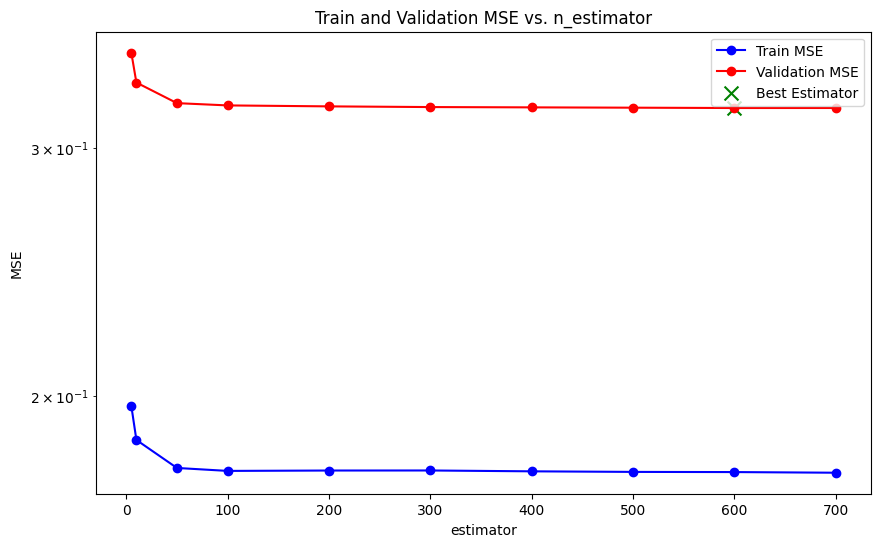

In [ ]:
estimators = [5, 10,50,100,200,300,400, 500, 600,700]
plt.figure(figsize=(10, 6))
plt.plot(estimators, train_mses_mean, marker='o', label='Train MSE', color='b')
plt.plot(estimators, val_mses_mean, marker='o', label='Validation MSE', color='r')

#Identify the degree with the lowest validation error
best_estimator= estimators[np.argmin(val_mses_mean)]

min_val_mse = min(val_mses_mean)
plt.scatter(best_estimator, min_val_mse, color='g', marker='x', s=100, label='Best Estimator')

plt.yscale('log')
plt.xlabel('estimator')
plt.ylabel('MSE')
plt.title('Train and Validation MSE vs. n_estimator')
plt.legend(loc=0)
plt.show()

In [ ]:
best_estimator

600

In [ ]:
base_model = DecisionTreeRegressor(max_depth=15, random_state=109)

bagging_regressor = BaggingRegressor(base_model, n_estimators = best_estimator, random_state=109)
bagging_regressor.fit(X_train_knnimputevalue, y_train_ravel)

y_test_pred = bagging_regressor.predict(X_test_knnimputevalue)
y_train_pred = bagging_regressor.predict(X_train_knnimputevalue)

evaluate_model('Decision Tree (Shallower) + Bagging',y_test_knnimputevalue, y_test_pred,y_train_knnimputevalue,y_train_pred,all_scores_pleqt)

The R^2 score of the best Decision Tree (Shallower) + Bagging model using the training data is 0.6045
The  MSE score of the best Decision Tree (Shallower) + Bagging model using the training data is 0.1837
The R^2 score of the best Decision Tree (Shallower) + Bagging model is 0.2917
The  MSE score of the best Decision Tree (Shallower) + Bagging model is 0.3100


In [ ]:
pd.DataFrame(all_scores_pleqt)

,model,train_mse,train_R2,test_mse,test_R2
0,Polynomial Regression,0.430889,0.072289,0.418559,0.043782
1,KNN,0.277717,0.402072,0.371647,0.150954
2,Decision Tree + Bagging,0.103494,0.777177,0.309627,0.292642
3,Decision Tree (Shallower) + Bagging,0.183702,0.604486,0.310027,0.291729


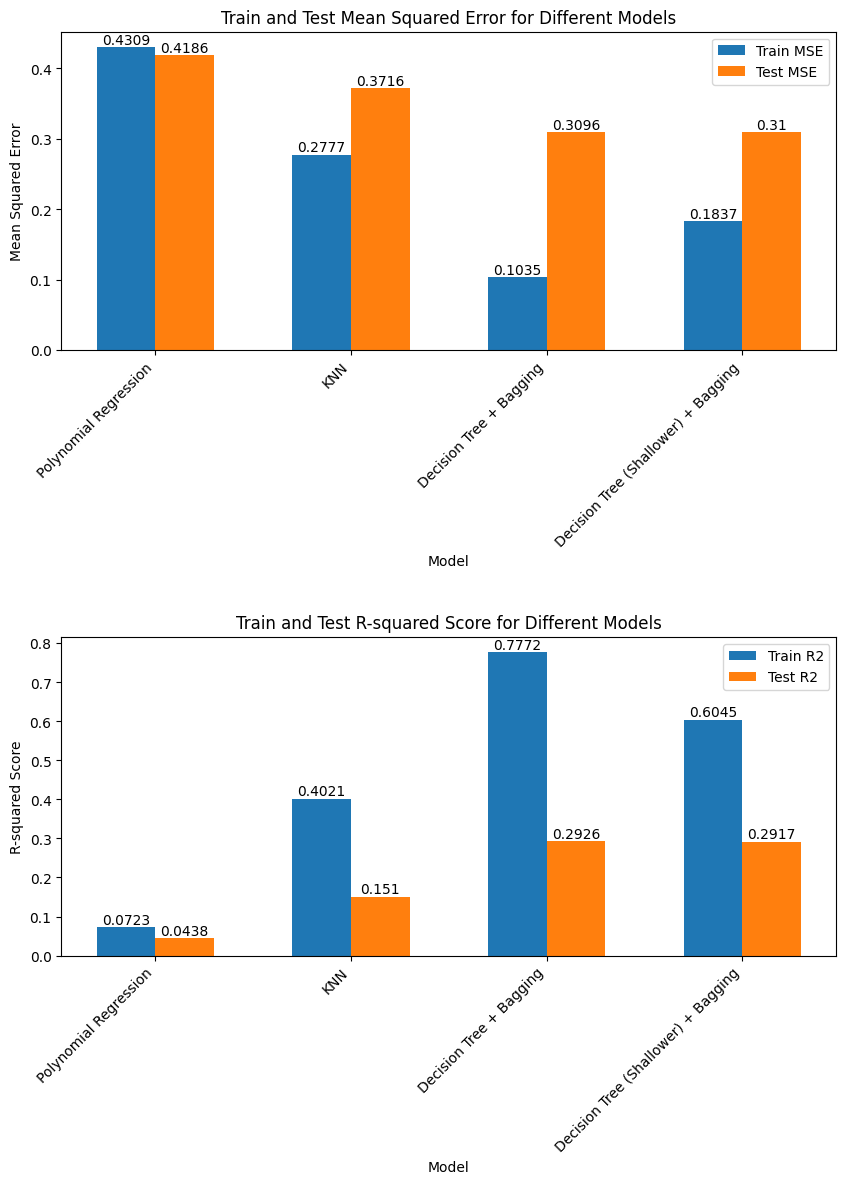

In [ ]:
plot_all_scores(all_scores_pleqt)

The bagging model shows higher R^2 values and lower MSE values. However the bagging model is significantly computationally heavier compared to the KNN model.  

<a id='conclusion'></a>
## Conclusion
[Return to contents](#contents1)

As we had identified in our EDA, there are a significant number of outliers inside the dataset that we are working on. This combined with the fact that the response dataset is not distributed normally as well as the residual plots not following the assumption of linearity, point us in the direction of a non-parametric model that can handle non linear relationships. From this KNN and bagging were both chosen as potential final models.

The decision tree with bagging model outperformed the other models when predicting the temperature and the mass of the exoplanet.

#### Further Analysis

The effectiveness of the decision tree model, particularly its depth, significantly impacts the Mean Squared Error and R-squared scores. Our experimentation with shallower trees aimed to mitigate overfitting. However, while this approach reduced overfitting, it didn't substantially enhance the accuracy of the model. This observation suggests the presence of an irreducible error, likely stemming from limitations in our data quality. Enhanced imputation methods or more robust data might be necessary to improve accuracy.

In order to better understand why the models we chose were good fits or not, it may be necessary to evaluate the data itself. One explanation behind the high correlation between the temperature of a planet and the stellar mass, radius and temperature is due to the temperature of the planet being measured by the light curve originally emitted by the star. The relationship between a planet's temperature, the radius, and temperature of a star can be found through a simple equation. Even if some observations are missing, these values can be computed trivially. Whether these computations are correct or not, they wouldn't have as much of an effect on the remaining data as outliers would, so this could be a useful course of action.

Unlike temperature, determining an exoplanet's mass typically requires direct observation, which can be challenging with current technology. The dataset of direct mass observations is comparatively smaller, leading to potential issues with missing values and outliers. In our models, especially those sensitive to outliers like linear regression and KNN, these data issues can significantly skew predictions.

The superior performance of the bagging model suggests its robustness in handling the complexities and limitations of our dataset. Bagging, being an ensemble method, effectively reduces the influence of outliers and variance in the data, leading to more reliable predictions.

Our chosen models have demonstrated promising results. Beyond the scope of this project, we would consider exploration of more advanced ensemble techniques and leveraging additional data sources to further refine our results.




